In [ ]:
# import modules, create output directory

import matplotlib.pyplot as pyplot
import numpy as np
import math
import os
import time as tm

import underworld as uw
uw.utils.matplotlib_inline()

from underworld import function as fn
import underworld.visualisation as vis

from scipy.spatial import Delaunay, cKDTree

if not os.getcwd().rsplit("/")[-1] == "output":
    
    outputPath = os.path.join(os.path.abspath("."),"output/")
    if not os.path.exists ( outputPath ):
        os.makedirs ( outputPath )

    os.chdir(outputPath)

### Example fold function + plot

In [ ]:
## !/usr/bin/env python3

# importing mplot3d toolkits, numpy and matplotlib

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# syntax for 3-D projection
fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# defining all 3 axes
Amplitude = 400. #half
Width = 16000.
Basis = 700.  #average thickness

azimuth = -36.
inclination = 0.

xsize = 50000.
ysize = 50000.

x = np.linspace(0, xsize, 1000)
y = np.linspace(0, ysize, 1000)

X, Y = np.meshgrid(x, y)

omega = 2. * np.pi / Width

def y_function(x, y, az = -54, incli=0):

    az = az / 180. * np.pi
    incli = incli / 180 * np.pi
    
    fc = np.cos(az)
    fs = np.sin(az)
    fi = np.tan(incli)

    xr = fc * x - fs * y
    yr = fs * x + fc * y

    return( Basis + fi * yr + Amplitude * np.sin( omega * xr) )

Z = y_function(X, Y, azimuth, inclination)

# plotting
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, cmap='gnuplot')
ax.set_title('3D folds')
plt.show()

In [ ]:
## basic parameters

g = 9.81
#ice_density = 910.

#A = 1e-16
n = 4.

Amplitude = 400.
Width = 20000.
Basis = 700.
Azimuth = -36
Inclination = 0
Number_of_folds = 2.

minX = 0.0
#maxX = Number_of_folds * Width
maxX = Number_of_folds * Width / np.cos((abs(Azimuth)) / 180. * np.pi)

minY = 0.0
maxY = 2500.0

iceHeight = 2500.

minZ = 0.0
maxZ = 15000.

resX = 10
resY = 8
resZ = 10

totSysVol = (maxX - minX) * (maxY - minY) * (maxZ - minZ)

elementType = "Q1/dQ0"
#elementType = "Q2/dQ1"
#elementType = "Q1/dPc1"
#elementType = "Q2/dPc1"

mesh = uw.mesh.FeMesh_Cartesian( elementType = ( elementType ) , 
                                 elementRes  = ( resX, resY, resZ ), 
                                 minCoord    = ( minX, minY, minZ ), 
                                 maxCoord    = ( maxX, maxY, maxZ ),
                                 periodic    = ( [True, False, False] ) 
                               ) 

velocityField    = mesh.add_variable(         dataType="double",  nodeDofCount=3 )
pressureField    = mesh.subMesh.add_variable( dataType="double",  nodeDofCount=1 )
directorField    = mesh.add_variable( dataType="double",  nodeDofCount=3 )

velocityField.data[:] = [0.,0.,0.]
directorField.data[:] = [0.,1.,0.]
pressureField.data[:] = 0.

## visualisation parameters

viz_opts = {
            #"figsize"     : (2000,400),
            "edgecolour"   :  "black",
            "quality"      :  3,          # antialiasing
            "align"        : "bottom",     # colour bar alignment
            #"size"        : (0.83,0.01), # colour bar size
            #"position"    : 0.,          # colour bar position
            #"boundingBox"  : ((minX, maxX), (minY, maxY), (minZ, maxZ)),
            "axis"         : True,
            "scale"        : True,
           }

In [4]:
# Create a swarm which will define our material geometries, and will also
# track deformation and history dependence of particles.
swarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True)
parts_per_cell = 200

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=parts_per_cell )
swarm.populate_using_layout( layout=swarmLayout )

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, aggressiveThreshold=0.7, particlesPerCell=parts_per_cell)

# create advector
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)

avPartVol = totSysVol / swarm.particleGlobalCount 
avPartEdge = avPartVol**(1./3.)

In [5]:
# Initialise particle properties 

dist = (maxX * maxY * maxZ / swarm.particleGlobalCount)**(1/3) # average distance between particles

materialVariable = swarm.add_variable( dataType="int", count=1 )
particleDensity = swarm.add_variable ( dataType="double", count=1 )

particleStrainrate = swarm.add_variable ( dataType="double", count=1 )
particleViscosity = swarm.add_variable ( dataType="double", count=1 )
particleShearstress = swarm.add_variable ( dataType="double", count=1 )

particleDirector = swarm.add_variable ( dataType="double", count=3 )
# particleMeshDirector below only used to save the director if calculated as a mesh variable
particleMeshDirector = swarm.add_variable ( dataType="double", count=3 ) 
particlePrefactor = swarm.add_variable ( dataType="double", count=1 )

particleWeakzone = swarm.add_variable ( dataType="int", count=1 )

particleTemperature = swarm.add_variable ( dataType="double", count=1 ) ###
particleTemperature.data[:] = 0.

particleSnowHeight = swarm.add_variable ( dataType="double", count=1 )
particleSnowHeight.data[:] = 0.

particleVelocity = swarm.add_variable( dataType="double", count=3 )
particleVelocity.data[:] = (0.,0.,0.)

iceSurf = swarm.add_variable ( dataType="int", count=1 )
iceSurf.data[:] = 0

particleCreationTime = swarm.add_variable ( dataType="float", count=1 )
particleCreationTime.data[:] = 0.

showPlane = swarm.add_variable ( dataType="int", count=1 )

foldHeight = swarm.add_variable( dataType="double", count=1 )

### Definition of materials


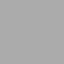

{}

In [6]:
materialV = 0  # viscoplastic ice
materialVC = 1 # viscoplastic ice in the channel

coord = fn.input()

#materialVariable.data[:] = materialV

az = Azimuth / 180. * np.pi
incli = Inclination / 180 * np.pi
omega = 2. * np.pi / Width

fc = np.cos(az)
fs = np.sin(az)
fi = np.tan(incli)

xr = fc * swarm.data[:, 0] - fs * swarm.data[:, 2]
zr = fs * swarm.data[:, 0] + fc * swarm.data[:, 2]
x = swarm.data[:, 0]
z = swarm.data[:, 2]

init = Basis + fi * zr + Amplitude * np.sin( omega * xr )
foldHeight.data[:] = np.expand_dims(init, 1)

conditions = [ 
               (       coord[1] < foldHeight,    materialVC    ),
               (       True ,           materialV                   ), 
             ]

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

particlePrefactor.data[:] = 1.
#particlePrefactor.data[np.where(particleWeakzone.data[:])] = 0.05

particleDirector.data[:] = (0., 1., 0.)

#figMaterials = vis.Figure(**viz_opts)
figMaterials = vis.Figure(title="Test")
figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=1.0, fn_mask=materialVariable, colourBar=True))
figMaterials.window()



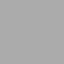

{}

In [7]:
## swarms to track the deformation
surfaceSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

xr = fc * swarm.data[:, 0] - fs * swarm.data[:, 2]
zr = fs * swarm.data[:, 0] + fc * swarm.data[:, 2]
x = swarm.data[:, 0]
z = swarm.data[:, 2]

# create pop control object
pop_control2 = uw.swarm.PopulationControl(surfaceSwarm)

# create advector
surfacePoints = np.array(np.meshgrid(np.linspace(0, maxX, 50), iceHeight, np.linspace(0., maxZ, 500))).T.reshape(-1, 3)

x = surfacePoints[:, 0]
z = surfacePoints[:, 2]
xr = fc * x - fs * z
zr = fs * x + fc * z

surfacePoints[:, 1] = Basis + fi * zr + Amplitude * np.sin( omega * xr )
surfaceSwarm.add_particles_with_coordinates(surfacePoints)

surfacePoints = np.array(np.meshgrid(np.linspace(0, maxX, 500), iceHeight, np.linspace(0., maxZ, 50))).T.reshape(-1, 3)
x = surfacePoints[:, 0]
z = surfacePoints[:, 2]
xr = fc * x - fs * z
zr = fs * x + fc * z

surfacePoints[:, 1] = Basis + fi * zr + Amplitude * np.sin( omega * xr )
surfaceSwarm.add_particles_with_coordinates(surfacePoints)
    
# to visualize the surface swarm in paraview we need a pseudo variable
surfaceParticle = surfaceSwarm.add_variable ( dataType="int", count=1 )
surfaceParticle.data[:] = 1

figSurf = vis.Figure(title="Test")
figSurf.append(vis.objects.Points(swarm, coord[1], pointSize=1.0, fn_mask=materialVariable, colourBar=True))
figSurf.append(vis.objects.Points(surfaceSwarm, pointSize=1.0, colourBar=True))
figSurf.window()

In [8]:
#Deriving A0 from several layers of differently temperated ice

R = 0.008314 # kJ / (T*mol)
Q = 181. # kJ/mol, activation energy
surf_velocity = 15.0 # m/a, velocity of ice
#alpha = 0.5 / 180. * np.pi
H = 2500. # m, height of the ice sheet
linearA0Factor = np.exp((60. - 181.) / (R * 258.))
#print(alpha)

def A0n4(T, Z):
    
    T = [tem + 273 for tem in T]
    zu = 0
    v = 0
    
    for tem, z in zip(T, Z):
        zl = zu
        zu = z
        rho = (18.02 / (19.30447 - 7.988471e-4 * tem + 7.563261e-6 * (tem**2) )) * 1000
        
        print (zl, zu, tem, rho)
        
        #try:
        #    zl < zu
        #except:
        #    print ("Laeuft nicht.")
        
        if tem <= 258:
            v = v + ( 5*H**4*zu - 10*H**3*zu**2 + 10*H**2*zu**3 - 5*H*zu**4 + zu**5 ) * np.exp(-Q / (R*tem)) * linearA0Factor
            v = v - ( 5*H**4*zl - 10*H**3*zl**2 + 10*H**2*zl**3 - 5*H*zl**4 + zl**5 ) * np.exp(-Q / (R*tem)) * linearA0Factor
        else:
            v = v + ( 5*H**4*zu - 10*H**3*zu**2 + 10*H**2*zu**3 - 5*H*zu**4 + zu**5 ) * np.exp(-Q / (R*tem))
            v = v - ( 5*H**4*zl - 10*H**3*zl**2 + 10*H**2*zl**3 - 5*H*zl**4 + zl**5 ) * np.exp(-Q / (R*tem))

    #v = v * 4e-25 * np.sin(alpha)**4 * g**4 * rho**4
    v = v * 4e-25 * g**4 * rho**4
    A0 = surf_velocity / v
    A0 = A0 / (86400*365)
    # return first A0 for T > 258, then A0 for T <= 258
    return (A0, A0 * linearA0Factor)

#coldice_temperature=243.15
#warmice_temperature=268.15
#coldice_density = (18.02 / (19.30447 - 7.988471e-4 * coldice_temperature + 7.563261e-6 * (coldice_temperature**2) )) * 1000
#warmice_density = (18.02 / (19.30447 - 7.988471e-4 * warmice_temperature + 7.563261e-6 * (warmice_temperature**2) )) * 1000

Z = [500, 2500]
T = [-5, -30]

A0highT, A0smallT = A0n4(T, Z)

print("A0 (T > 258) = " + str(A0highT) + ", A0 (T <= 258): " + str(A0smallT))

0 500 268 917.8142358669418
500 2500 243 921.4114212256626
A0 (T > 258) = 5.15946734957e+20, A0 (T <= 258): 0.000163711369464



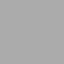


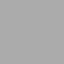

{}

In [9]:
#Temperature

T0 = -30. # °C
Tbed = -5. # °C
Basis = 700.

DeltaT = Tbed - T0

coord = fn.input()

#temperatureField= mesh.add_variable(         dataType="double",  nodeDofCount=1 )
#temperatureField.data[:] = Tbed

az = Azimuth / 180. * np.pi
incli = Inclination / 180 * np.pi
omega = 2. * np.pi / Width

fc = np.cos(az)
fs = np.sin(az)
fi = np.tan(incli)

xr = fc * swarm.data[:, 0] - fs * swarm.data[:, 2]
zr = fs * swarm.data[:, 0] + fc * swarm.data[:, 2]

init = Basis + fi * zr + Amplitude * np.sin( omega * xr )
#foldHeightMesh = mesh.add_variable( dataType="double", nodeDofCount=1 )
foldHeight.data[:] = np.expand_dims(init, 1)

ds = Basis - Amplitude
T_func = T0 + DeltaT * ((1. - ((Basis - (foldHeight - coord[1])) / Basis))**2)

Tconditions = [
                (       coord[1] > foldHeight,    T0      ),
                (       coord[1] > foldHeight - Basis,    T_func  ),
                (       True,                             Tbed    ),
             ]

particleTemperature.data[:] = fn.branching.conditional( Tconditions).evaluate(swarm)

figT = vis.Figure(title="Temperature")
#figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.append(vis.objects.Points(surfaceSwarm, pointSize=1.0, colourBar=True))
figT.window()

figMaterials = vis.Figure(title="Folds")
#figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=1.0,fn_mask=materialVariable, colourBar=True))
figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=1.0,fn_mask=materialVariable, colourBar=True))
figMaterials.window()


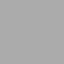


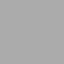

{}

In [10]:
T0 = -30. # °C
Tbed = -5. # °C
T_Basis = Basis

DeltaT = Tbed - T0

coord = fn.input()

az = Azimuth / 180. * np.pi
incli = Inclination / 180 * np.pi
omega = 2. * np.pi / Width

fc = np.cos(az)
fs = np.sin(az)
fi = np.tan(incli)

xr = fc * swarm.data[:, 0] - fs * swarm.data[:, 2]
zr = fs * swarm.data[:, 0] + fc * swarm.data[:, 2]

init = fi * zr + Amplitude * np.sin( omega * xr )
foldHeight.data[:] = np.expand_dims(init, 1)

ds = Basis - Amplitude
#T_func = T0 + DeltaT * ((1.-((Basis - (foldHeight - coord[1])) / Basis))**2)
T_func = T0 + DeltaT * ((T_Basis+foldHeight - coord[1]) / (T_Basis)) **2

Tconditions = [ 
                (       coord[1] > T_Basis + foldHeight,  T0      ),
                (       coord[1] > foldHeight,            T_func  ),
                (       True,                             Tbed    ),
              ]

particleTemperature.data[:] = fn.branching.conditional( Tconditions ).evaluate(swarm)

figT = vis.Figure(title="Temperature")
#figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.append(vis.objects.Points(surfaceSwarm, pointSize=1.0, colourBar=True))
figT.window()

#figMaterials = vis.Figure(title="Folds")
#figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=1.0, fn_mask=materialVariable, colourBar=True))
#figMaterials.append(vis.objects.Points(swarm, coord[1], pointSize=1.0, fn_mask=materialVariable, colourBar=True))
#figMaterials.window()


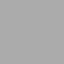


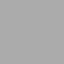


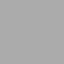

{}

In [26]:
## functions, incl flow law
R = 0.008314 # kJ / (T*mol)
QhighT = 181. # kJ/mol, activation energy
QsmallT = 60.

strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn  = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn  = fn.misc.constant(1e+12 / 3.1536e7)

V1 = 0.5 * (A0smallT * fn.math.exp(-QsmallT / (R*(particleTemperature + 273.)))) ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / n))
V2 = 0.5 * (A0highT * fn.math.exp(-QhighT / (R*(particleTemperature + 273.)))) ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / n))

VisBaseconditions = [
                (       particleTemperature <= -15., V1 ), 
                (       True,                        V2),               
                ]

#viscosityMap1 = {
#                materialV:  viscosityFnIce ,
#                materialVC: viscosityFnIce,
#               }

#viscosityMap2 = { 
#                 materialV:  viscosityFnColdIce,
#                materialVC: viscosityFnWarmIce,
#               }

viscosityFn1 = fn.branching.conditional( VisBaseconditions )
viscosityFn = fn.misc.max(fn.misc.min(viscosityFn1, maxViscosityIceFn), minViscosityIceFn)

particleViscosity.data[:] = viscosityFn.evaluate(swarm)

figVisc = vis.Figure(**viz_opts)
visc = vis.objects.Points(swarm, particleViscosity, pointSize=3.0, colourBar=True)
figVisc.append(visc)
figVisc.window()

figT = vis.Figure(title="Temperature")
#figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.append(vis.objects.Points(swarm, particleTemperature, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figT.window()

figS = vis.Figure(title="Strainrate")
figS.append(vis.objects.Points(swarm, strainRate_2ndInvariantFn, pointSize=3.0, fn_mask=materialVariable, colourBar=True))
figS.window()

In [27]:
devStressFn = 2.0 * viscosityFn1 * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn1 * 2.0

densityFnIce = (18.02 / (19.30447 - 7.988471e-4 * (particleTemperature+273.) + 7.563261e-6 * ((particleTemperature+273.)**2) )) * 1000.

densityFnAir = fn.misc.constant( 0. )
densityFnHAir = fn.misc.constant( 0. )

densityMap = {
                materialV:  densityFnIce,
                materialVC:  densityFnIce,
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination), 0.)

#z_hat = (0., -1., 0.)
#buoyancyFn = densityFn * z_hat * g


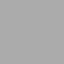

{}

In [28]:
## set boundary conditions
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]
outerkWall = mesh.specialSets["MinK_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]
leftWall = mesh.specialSets["MinK_VertexSet"]
rightWall = mesh.specialSets["MaxK_VertexSet"]

allWalls = iWalls + jWalls + kWalls

velocityField.data[:] = 0.
velocityField.data[outerkWall, 0] = 55.

velocityBCs = uw.conditions.DirichletCondition(
                                                variable        = velocityField, 
                                                indexSetsPerDof = (kWalls + base, base + top, kWalls + base),
                                              )

for index in np.ndindex(velocityField.data.shape[0]):
    if mesh.data[index][2] > 0:
        velocityField.data[index][0] = 15.

figOutFlow = vis.Figure()
figOutFlow.append(vis.objects.VectorArrows(mesh, velocityField,))
figOutFlow.append(vis.objects.Points(surfaceSwarm, pointSize=1.0, colourBar=False, colour='Blue'))
#figOutFlow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))

figOutFlow.window()

In [29]:
## setup solver and solve

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            velocityBCs,
            ],
    fn_viscosity=viscosityFn,
    #_fn_viscosity2=viscosityFn2,
    #_fn_director=directorField,
    #_fn_director=particleDirector,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7) # higher penalty = larger stability + (often) faster calculation
# solver.options.scr.ksp_rtol = 1.0e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    # print (f'Calibration pressure {p0 / area}')

# test it out
try:
    #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)


 
Pressure iterations:   7
Velocity iterations:   1 (presolve)      
Velocity iterations:   7 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   9 (total solve)   
 
SCR RHS  setup time: 2.2005e-01
SCR RHS  solve time: 4.9012e-03
Pressure setup time: 4.4966e-04
Pressure solve time: 3.1874e-02
Velocity setup time: 2.3842e-06 (backsolve)
Velocity solve time: 4.0302e-03 (backsolve)
Total solve time   : 2.9100e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 




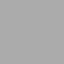

{}

In [30]:
## figOutflow
figOutFlow = vis.Figure()
figOutFlow.append(vis.objects.VectorArrows(mesh, velocityField, ))
#figOutFlow.append(vis.objects.Points(surfaceSwarm, pointSize=1.0, colourBar=False, colour='Blue'))
#figOutFlow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))

figOutFlow.window()


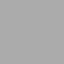

{}

In [34]:
figVisc = vis.Figure(**viz_opts)
visc = vis.objects.Points(swarm, particleViscosity, pointSize=3.0, colourBar=True)
figVisc.append(visc)
figVisc.window()

In [32]:
def c_axis_rotation(dt, steps = 1.):

    dt /= steps
    
    for i in range(0, int(steps)):
        
        iceIndices = np.array(np.where(materialVariable.data == materialV)[0])
        
        velGrad = velocityField.fn_gradient.evaluate(  swarm ).reshape(swarm.particleGlobalCount , mesh.dim, mesh.dim)
        velGrad = velGrad[iceIndices]
        velGradT = velGrad.swapaxes(-1,1)

        # rate of deformation and rate of rotation
        D = 0.5 * (velGrad + velGradT)
        W = 0.5 * (velGrad - velGradT)

        particleDirector.data[iceIndices] = particleDirector.data[iceIndices] + dt * ( np.einsum("ijk,ik->ij", W, particleDirector.data[iceIndices]) - np.einsum("ijk,ik->ij", D, particleDirector.data[iceIndices]) + np.einsum("ij,ij->i",particleDirector.data[iceIndices], np.einsum("ijk,ik->ij",D,particleDirector.data[iceIndices]))[:,None] * particleDirector.data[iceIndices])

        #finally normalize the c-axes
        particleDirector.data[iceIndices] = particleDirector.data[iceIndices] / np.absolute(np.linalg.norm(particleDirector.data[iceIndices], axis=1).reshape(len(iceIndices),1))

        # we want to rotate all directors, if they point towards the negative y-direction
        # this should make it easier to display them
        b = np.where(particleDirector.data[:,1] < 0.)
        particleDirector.data[b] *= -1.


In [33]:
def c_axis_rotation_mesh(dt, steps = 1.):

    dt /= steps
    
    for i in range(0, int(steps)):

        velGrad = velocityField.fn_gradient.evaluate(  mesh ).reshape(mesh.nodesGlobal, mesh.dim, mesh.dim)
        velGradT = velGrad.swapaxes(-1,1)

        # rate of deformation and rate of rotation
        D = 0.5 * (velGrad + velGradT)
        W = 0.5 * (velGrad - velGradT)
        
        directorField.data[:] = directorField.data[:] + dt * ( np.einsum("ijk,ik->ij", W, directorField.data[:]) - np.einsum("ijk,ik->ij", D, directorField.data[:]) + np.einsum("ij,ij->i",directorField.data[:], np.einsum("ijk,ik->ij",D,directorField.data[:]))[:,None] * directorField.data[:])

        #finally normalize the c-axes
        directorField.data[:] = directorField.data[:] / np.absolute(np.linalg.norm(directorField.data[:], axis=1).reshape(len(directorField.data),1))

        # we want to rotate all directors, if they point towards the negative y-direction
        # this should make it easier to display them
        b = np.where(directorField.data[:,1] < 0.)
        directorField.data[b] *= -1.
        
    particleMeshDirector.data[:] = directorField.evaluate( swarm )

In [ ]:
advector2 = uw.systems.SwarmAdvector(swarm=surfaceSwarm,velocityField=velocityField, order=2)

def flow(rotate_caxes = False):
    
    global calibrate_pressure
    global advector1
    global advector2
    global pop_control1
       
    #solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)

    # Retrieve the maximum possible timestep for the advection system.
    dt = min([advector1.get_max_dt(), advector2.get_max_dt()])

    #print(f'Calculating {dt}, leaving {t}')

    # Advect using this timestep size.
    advector1.integrate(dt) # the swarm
    advector2.integrate(dt) # the surface swarm

    # particle population control
    pop_control1.repopulate()
    #pop_control2.repopulate()

    if rotate_caxes:
        c_axis_rotation(dt, steps = 100.)
        c_axis_rotation_mesh(dt, steps = 100.)

    return (dt)


In [ ]:
maxSteps = 10001
stepsize = 50.   

step = 0
t = 0.

figSurf = vis.Figure(viz_opts)
surf = vis.objects.Points(swarm, materialVariable, pointSize=1.0, colourBar=True)
figSurf.append(surf)

figSnowHeight = vis.Figure(viz_opts)
height = vis.objects.Points(swarm, particleSnowHeight, pointSize=1.0, colourBar=True)
figSnowHeight.append(height)

xdmf_mesh    = mesh.save('mesh.h5')

while step < maxSteps:

    print ("in step " + str(step))

    #snowfallHA(stepsize, mpa, step*stepsize)
    t += flow(rotate_caxes = False)

    
    #figSurf.save("surf_" + str(step) + ".png")
    #figSnowHeight.save("snowheight_" + str(step) + ".png")
    
    if not step%stepsize: # if multiple of ..
        
        #print ("in step " + str(step))
        
        ignore = swarm.save('swarm_' + str(step) + '.h5')
        
        # eval swarm variables
        particleStrainrate.data[:] = strainRate_2ndInvariantFn.evaluate(swarm)
        particleViscosity.data[:] = viscosityFn1.evaluate(swarm)
        particleShearstress.data[:] = shearStressFn.evaluate(swarm)
        
        # save swarm variables as xdmf files
        xdmf_swarm = swarm.save('swarm_' + str(step) + '.h5')
        xdmf_surfswarm = surfaceSwarm.save('surf_swarm_' + str(step) + '.h5')
        
        xdmf_surfaceParticle = surfaceParticle.save('surfaceSwarm_' + str(step) + '.h5')
        surfaceParticle.xdmf('surfaceSwarm_' + str(step) + '.xdmf', xdmf_surfaceParticle,
                            "surfaceParticle", xdmf_surfswarm, "SurfSwarm", modeltime=step)

        xdmf_meshvar = velocityField.save('velocityField_' + str(step) + '.h5')
        velocityField.xdmf('velocityField_' + str(step) + '.xdmf', xdmf_meshvar, "Velocity", 
                           xdmf_mesh, "Mesh", modeltime=step)

        xdmf_particleStrainrate = particleStrainrate.save('particleStrainrate_' + str(step) + '.h5')
        particleStrainrate.xdmf('particleStrainrate_' + str(step) + '.xdmf', xdmf_particleStrainrate, 
                                "particleStrainrate", xdmf_swarm, "Swarm", modeltime=step)

        #xdmf_particleDirector = particleDirector.save('particleDirector_' + str(step) + '.h5')
        #particleDirector.xdmf('particleDirector_' + str(step) + '.xdmf', xdmf_particleDirector, 
        #                      "particleDirector", xdmf_swarm, "Swarm", modeltime=step)

        #xdmf_particleMeshDirector = particleMeshDirector.save('particleMeshDirector_' + str(step) + '.h5')
        #particleMeshDirector.xdmf('particleMeshDirector_' + str(step) + '.xdmf', xdmf_particleMeshDirector, 
        #                      "particleMeshDirector", xdmf_swarm, "Swarm", modeltime=step)
        
        xdmf_particleViscosity = particleViscosity.save('particleViscosity_' + str(step) + '.h5')
        particleViscosity.xdmf('particleViscosity_' + str(step) + '.xdmf', xdmf_particleViscosity, 
                                "particleViscosity", xdmf_swarm, "Swarm", modeltime=step)
        
        #xdmf_particleCreationTime = particleCreationTime.save('particleCreationTime_' + str(step) + '.h5')
        #particleCreationTime.xdmf('particleCreationTime_' + str(step) + '.xdmf', xdmf_particleCreationTime, 
        #                        "particleCreationTime", xdmf_swarm, "Swarm", modeltime=step)

        xdmf_materialVariable = materialVariable.save('particleMaterial_' + str(step) + '.h5')
        materialVariable.xdmf('particleMaterial_' + str(step) + '.xdmf', xdmf_materialVariable, 
                              "materialVariable", xdmf_swarm, "Swarm", modeltime=step)
    
        
        # visualizing the velocityField in paraviewe doesn't work for whatever reason (Paraview just crashes)
        # so we save it as a particle property
        particleVelocity.data[:]  = velocityField.evaluate(swarm)
        xdmf_particleVelocity = particleVelocity.save('particleVelocity_' + str(step) + '.h5')
        particleVelocity.xdmf('particleVelocity_' + str(step) + '.xdmf', xdmf_particleVelocity, 
                      "particleVelocity", xdmf_swarm, "Swarm", modeltime=step)
        
        print (str(t) + ' years, step: ' + str(step))
        
    step += 1

In [ ]:
# Visualize the saved swarm data

swarm2    = uw.swarm.Swarm(mesh)
swarmVariable2 = swarm2.add_variable(dataType='int', count=1)
particleViscosity2 = swarm2.add_variable(dataType='double', count=1)
particleMaterial2 = swarm2.add_variable(dataType='double', count=1)
particleStrainrate2 = swarm2.add_variable(dataType='double', count=1)
particleVelocity2 = swarm2.add_variable(dataType='double', count=3)

swarm2.load('swarm_' + str(step-100.0) + '.h5')
swarmVariable2.load('surfaceSwarm_' + str(step-100.0) + '.h5')
particleViscosity2.load('particleViscosity_' + str(step-100.0) + '.h5')
particleMaterial2.load('particleMaterial_' + str(step-100.0) + '.h5')
particleStrainrate2.load('particleStrainrate_' + str(step-100.0) + '.h5')
particleVelocity2.load('particleVelocity_' + str(step-100.0) + '.h5')

map_dict = { 
            materialV:0.,
            materialVC:1., 
           }

fn_map = fn.branching.map( fn_key = swarmVariable2, 
                          mapping = map_dict )

figSurf = vis.Figure(title="SurfaceSwarm")
surf = vis.objects.Points(swarm2, swarmVariable2, fn_mask=fn_map, pointSize=1.0, colourBar=True)
figSurf.append(surf)
figSurf.window()

figMate = vis.Figure(title="Material")
mate = vis.objects.Points(swarm2, particleMaterial2, fn_mask=fn_map, pointSize=1.0, colourBar=True)
figMate.append(mate)
figMate.window()

figStra = vis.Figure(title="StrainRate")
stra = vis.objects.Points(swarm2, particleStrainrate2, fn_mask=fn_map, pointSize=1.0, colourBar=True, colours='blue red')
figVisc.append(stra)
figVisc.window()

figVelo = vis.Figure(title="Velocity")
velo = vis.objects.Points(swarm2, particleVelocity2, fn_mask=fn_map, pointSize=1.0, colourBar=True, colours='blue red')
figVisc.append(velo)
figVisc.window()


In [ ]:
# Visualize the saved swarm data
swarm2    = uw.swarm.Swarm(mesh)
swarmVariable2 = swarm2.add_variable(dataType='int', count=1)
particleSnowHeight2 = swarm2.add_variable(dataType='double', count=1)
particleViscosity2 = swarm2.add_variable(dataType='double', count=1)
particleDirector2 = swarm2.add_variable ( dataType="double", count=3 )

swarm2.load('swarm_' + str(step-10.0) + '.h5')
swarmVariable2.load('surfaceSwarm_' + str(step-10.0) + '.h5')
particleSnowHeight2.load('particleSnowHeight_' + str(step-10.0) + '.h5')
particleViscosity2.load('particleViscosity_' + str(step-10.0) + '.h5')
particleDirector2.load('particleDirector_' + str(step-10.0) + '.h5')

map_dict = { 
            materialV:1.,
            materialA:0.,
            materialHA:0.,
           }

fn_map = fn.branching.map( fn_key = swarmVariable2, 
                          mapping = map_dict )

figSurf = vis.Figure(**viz_opts)
surf = vis.objects.Points(swarm2, swarmVariable2, fn_mask=fn_map, pointSize=1.0, colourBar=True)
figSurf.append(surf)

figSnowHeight = vis.Figure(**viz_opts)
height = vis.objects.Points(swarm2, particleSnowHeight2, pointSize=1.0, colourBar=True)
figSnowHeight.append(height)

figVisc = vis.Figure(**viz_opts)
visc = vis.objects.Points(swarm2, particleViscosity2, fn_mask=fn_map, pointSize=1.0, colourBar=True, colours='blue red')
figVisc.append(visc)

figYDirector = vis.Figure(**viz_opts)
ydir = vis.objects.Points(swarm2, particleDirector2[1], pointSize=1.0, colourBar=True)
figYDirector.append(ydir)

figSurf.window()
figVisc.window()
figSnowHeight.window()
figYDirector.window()